In [1]:
import pandas as pd
import numpy as np
from datetime import date

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import plotly.express as px

# formats axes labels from ie 1000000 to $1,000,000
dollar_formattor = mtick.StrMethodFormatter('${x:,.0f}')

### Overview

This notebook is David Robinson's movie-profit R analysis translated into python.

Original Links:
- Youtube: https://www.youtube.com/watch?v=3-DRwg9yeNA&t=1s
- R code: https://github.com/dgrtwo/data-screencasts/blob/master/movie-profit.Rmd

### Data

In [2]:
movie_profit_raw = pd.read_csv(
    # file used in screencast was updated with clean version hence had to use old commit url 
    'https://raw.githubusercontent.com/rfordatascience/tidytuesday/d178f166c10ef2e0d4d301e97fb7521e137b2dd3/data/2018-10-23/movie_profit.csv',
     parse_dates=['release_date'],
)

### Data cleaning

In [3]:
# removing first column as just an index
movie_profit = movie_profit_raw.drop(movie_profit_raw.columns[0], axis=1)

# only including: dates pre 2018, not null distributors, worldwide_gross > 0
movie_profit = movie_profit[(movie_profit.release_date < pd.to_datetime('2018-01-01')) & 
                            (movie_profit.distributor.notnull()) &
                            (movie_profit.worldwide_gross > 0)]

# removing duplicate movie rows
movie_profit = movie_profit.sort_index(ascending=False)
movie_profit = movie_profit.drop_duplicates(['movie', 'release_date'], keep = 'first')

# everything outside top 5 distributors label 'Other'
top_distributors = movie_profit.distributor.value_counts(sort=True).index[:5]
movie_profit.loc[~movie_profit.distributor.isin(top_distributors), 'distributor'] = 'Other'

movie_profit['profit_ratio'] = movie_profit.worldwide_gross / movie_profit.production_budget

movie_profit['decade'] = (movie_profit.release_date.dt.year // 10) * 10

### What genres make the most money?

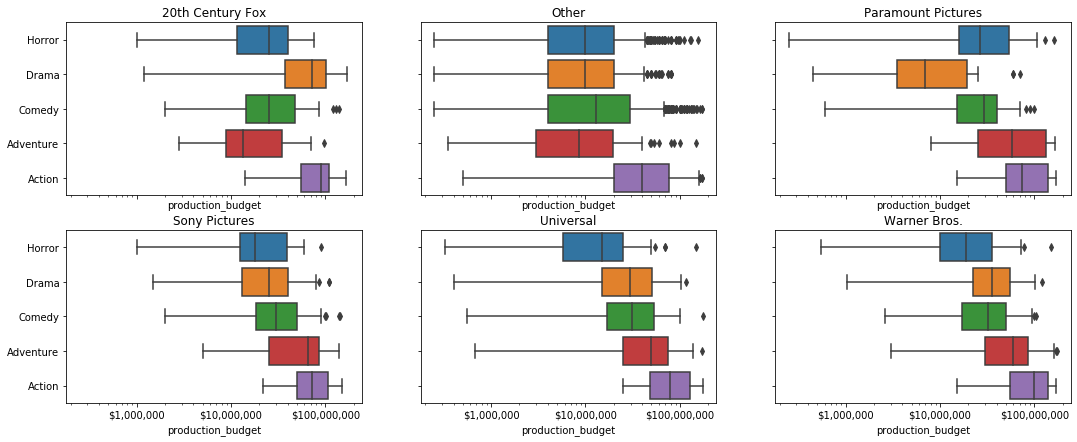

In [4]:
f, ax = plt.subplots(2, 3, figsize=(18,7), sharey=True, sharex=True)

for i, (distributor, df) in enumerate(movie_profit.groupby('distributor')):
    row, col = i//3, i%3
        
    sns.boxplot(x = 'production_budget',
                y = 'genre',
                data = df,
                ax = ax[row, col],
                orient = 'h')
    
    ax[row,col].set_title(distributor)
    
    ax[row,col].set_xscale('log', basex=10)
    ax[row,col].xaxis.set_major_formatter(dollar_formattor)

    ax[row,col].set_ylabel(None)
    

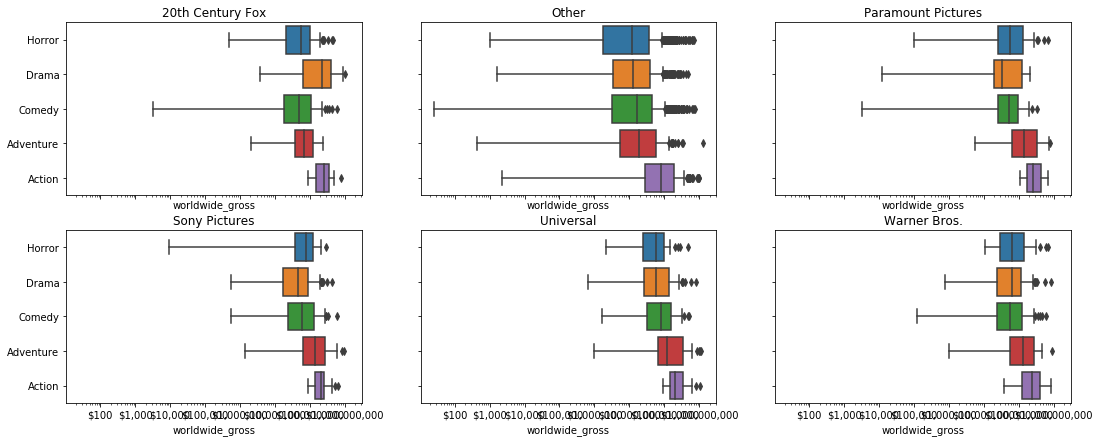

In [5]:
f, ax = plt.subplots(2, 3, figsize=(18,7), sharey=True, sharex=True)

for i, (distributor, df) in enumerate(movie_profit.groupby('distributor')):
    row, col = i//3, i%3
        
    sns.boxplot(x = 'worldwide_gross',
                y = 'genre',
                data = df,
                ax = ax[row, col],
                orient = 'h')
    
    ax[row,col].set_title(distributor)
    
    ax[row,col].set_xscale('log', basex=10)
    ax[row,col].xaxis.set_major_formatter(dollar_formattor)
    
    ax[row,col].set_ylabel(None)

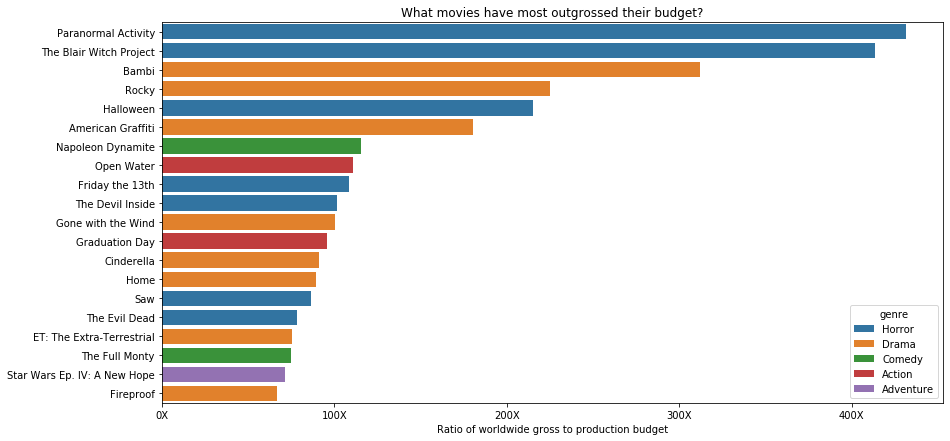

In [6]:
f, ax = plt.subplots(figsize=(14,7))

data = movie_profit.sort_values(by='profit_ratio',ascending=False)

sns.barplot(x = 'profit_ratio',
            y = 'movie',
            hue = 'genre',
            data = data.head(20),
            dodge = False)

ax.set_ylabel(None)

ax.set_xlabel("Ratio of worldwide gross to production budget")
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0f}X'))

ax.set_title('What movies have most outgrossed their budget?')

plt.show()

### What are the most common genres over time?

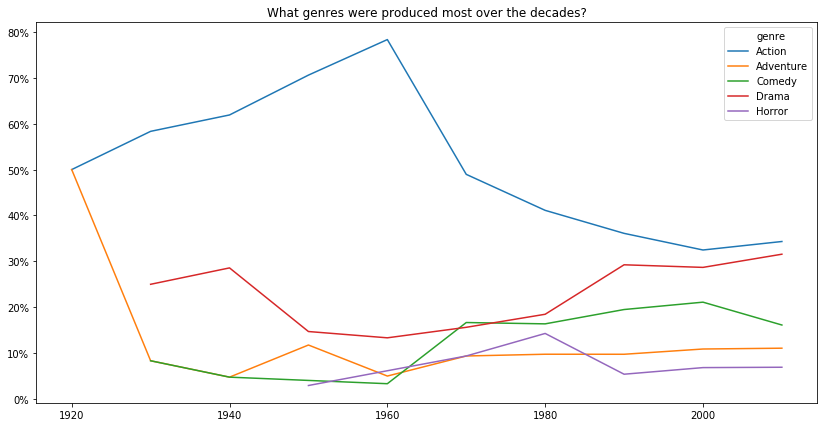

In [7]:
f, ax = plt.subplots(figsize=(14,7))

# df of count of movies by genre by decade
data = movie_profit.groupby(['decade', 'genre'])['movie'].count().reset_index(name='genre_movies')
# total movies per decade
data['total_movies'] = data.decade.map(data.groupby('decade')['genre_movies'].sum())
# percent of genre in decade total
data['percent'] = data['genre_movies'] / data['total_movies']

sns.lineplot(x = 'decade',
             y = 'percent',
             hue = 'genre',
             data = data,
             ax = ax)

ax.set_xlabel(None)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
ax.set_ylabel(None)

ax.set_title('What genres were produced most over the decades?')

plt.show()

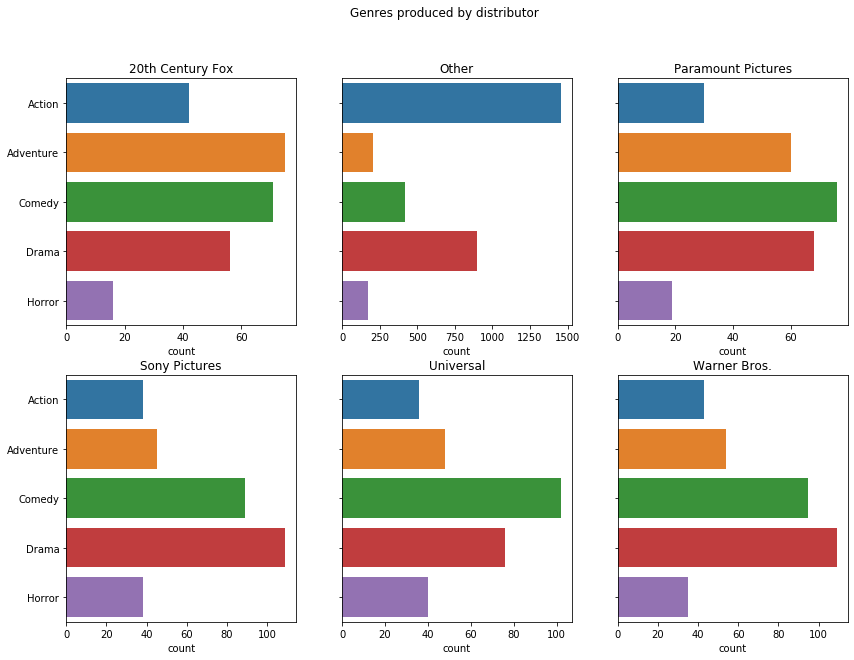

In [8]:
f, ax = plt.subplots(2, 3, figsize=(14,10), sharey=True)

for i, (distributor, df) in enumerate(movie_profit.groupby('distributor')):
    row, col = i//3, i%3
    
    # adding movie count to data
    data = df.groupby('genre')['movie'].count().reset_index(name = 'count')
    
    # did this as count plot wouldn't plot horizontal in subplot
    sns.barplot(x = 'count',
                y = 'genre',
                data = data,
                ax = ax[row, col],
                orient = 'h')
    
    ax[row,col].set_ylabel(None)
    
    ax[row,col].set_title(distributor)
    
f.suptitle('Genres produced by distributor')

plt.show()

### Which genres have the biggest payoff?
We're looking at ratio of worldwide gross to production budget

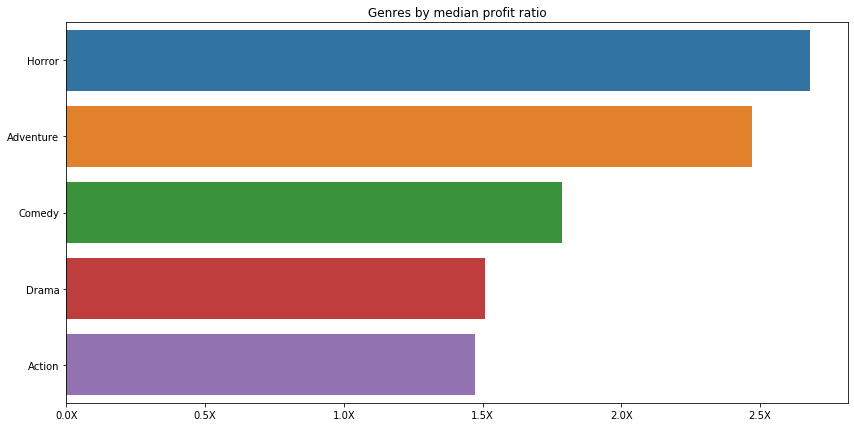

In [9]:
f, ax = plt.subplots(figsize=(14,7))

# median profit ratio by genre
data = movie_profit.groupby('genre')['profit_ratio'].median()\
                                                        .sort_values(ascending=False)\
                                                        .reset_index(name='median_profit_ratio')

sns.barplot(x = 'median_profit_ratio',
            y = 'genre',
            data = data, 
            orient='h')

ax.set_ylabel(None)

ax.set_xlabel(None)
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.1f}X'))

ax.set_title('Genres by median profit ratio')

plt.show()

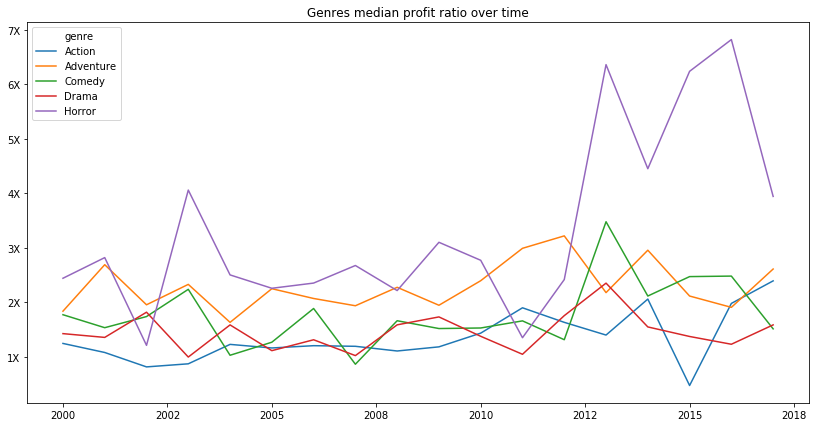

In [10]:
f, ax = plt.subplots(figsize=(14,7))


data = movie_profit[movie_profit.release_date.dt.year >= 2000].copy()
data['year'] = data.release_date.dt.year
data = data.groupby(['genre', 'year'])['profit_ratio'].median().reset_index(name='median_profit_ratio')

sns.lineplot(x = 'year',
             y = 'median_profit_ratio',
             hue = 'genre',
             data = data,
             ax = ax)

ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0f}X'))
ax.set_ylabel(None)

ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0f}'))
ax.set_xlabel(None)

ax.set_title('Genres median profit ratio over time')
plt.show()

Wow, horror movies have been very profitable in the last few years! What were some of those profitable horror movies?

In [11]:
horror_movies = movie_profit[movie_profit.genre == 'Horror'].sort_values(by='profit_ratio', ascending=False)

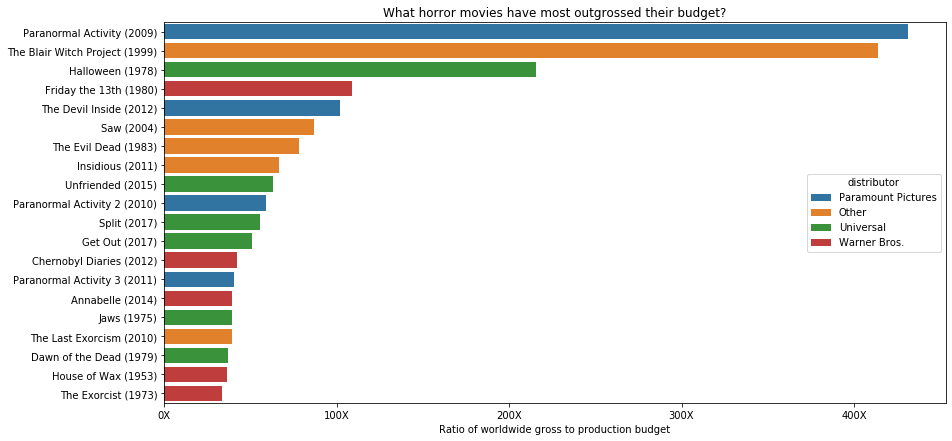

In [12]:
f, ax = plt.subplots(figsize=(14,7))

sns.barplot(x = 'profit_ratio',
            y = 'movie',
            hue = 'distributor',
            data = horror_movies.head(20),
            dodge = False)

ax.set_ylabel(None)

ax.set_xlabel("Ratio of worldwide gross to production budget")
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0f}X'))

ax.set_title('What horror movies have most outgrossed their budget?')

# adding new labels formatted as: movie (year)
ax.set_yticklabels([f'{movie} ({year})' for movie, year in 
                    zip(horror_movies.movie, horror_movies.release_date.dt.year)])

plt.show()

Horror movies started being more profitable around 2013.

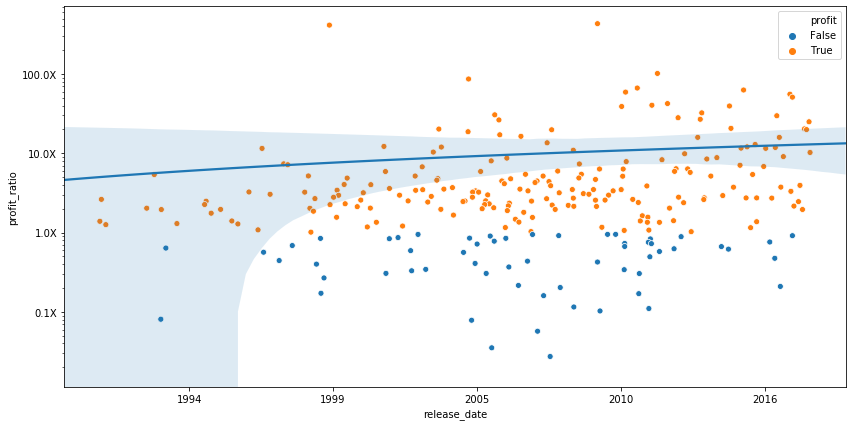

In [13]:
f, ax = plt.subplots(figsize=(14,7))

# converting to ordinal date in order to fit regression line
horror_movies['ordinal_date'] = horror_movies.release_date.apply(lambda date: date.toordinal())

data = horror_movies[(horror_movies.release_date >= '1990-01-01') & (horror_movies.profit_ratio >= .01)].copy()

data['profit'] = data.profit_ratio > 1

sns.scatterplot(x='ordinal_date',
                y='profit_ratio',
                data=data,
                hue='profit',
                ax=ax)

sns.regplot(x='ordinal_date',
            y='profit_ratio',
            data=data,
            scatter=False,
            ax=ax)

ax.set_yscale('log', basey=10)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.1f}X'))

ax.set_xlabel('release_date')
# converting back to year format
new_labels = [date.fromordinal(int(item)).year for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)

plt.show()

In [14]:
data = movie_profit[(movie_profit.release_date >= '1990-01-01') & 
                    (movie_profit.profit_ratio >= .01)]

fig = px.scatter(data, 
                 x='release_date', 
                 y='profit_ratio', 
                 trendline='ols', 
                 trendline_color_override='red',
                 hover_name='movie',
                 facet_col='genre',
                 log_y=True)

fig.show()

### What are typical budgets over time?

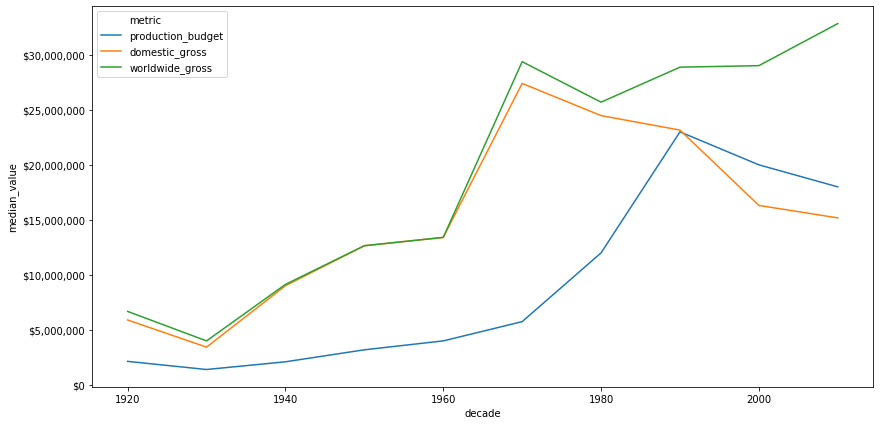

In [15]:
f, ax = plt.subplots(figsize=(14,7))

# median figures by decade
data = movie_profit.groupby('decade')[['production_budget', 'domestic_gross', 'worldwide_gross']]\
                                                                                            .median()\
                                                                                            .reset_index()
# coverting figure columns to rows
data = data.melt(id_vars='decade', 
                 var_name='metric', #'production_budget', 'domestic_gross', 'worldwide_gross'
                 value_name='median_value') # figures relating to metric

sns.lineplot(x = 'decade',
             y = 'median_value',
             hue = 'metric',
             data = data)

ax.yaxis.set_major_formatter(dollar_formattor)

### Future work
* Didn't look at domestic vs worldwide revenue
* Didn't look at MPAA ratings
* Haven't tried a predictive model


### Untitled
workings in RMD without specific header

In [16]:
# count movies produced by each distributor
movie_profit['distributor'].value_counts(sort=True, ascending=False)

Other                 3146
Warner Bros.           336
Sony Pictures          319
Universal              302
20th Century Fox       260
Paramount Pictures     253
Name: distributor, dtype: int64

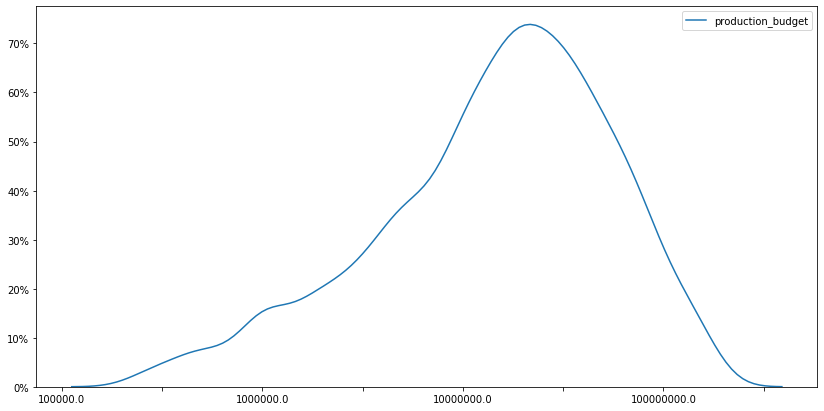

In [17]:
'''
kde plot didn't work well plotting and then setting x scale to log10.
So instead plotted the log10 values then converted the labels back to dollar values
'''

f, ax = plt.subplots(figsize=(14,7))

sns.kdeplot(np.log10(movie_profit.production_budget),
            ax=ax)

# have to draw before getting labels
f.canvas.draw()

# only labeling whole numbers otherwise values will get messy
new_labels = [10**float(val.get_text()) if (float(val.get_text()) % 1) == 0 else '' for val in ax.get_xticklabels()]

ax.set_xticklabels(new_labels)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))

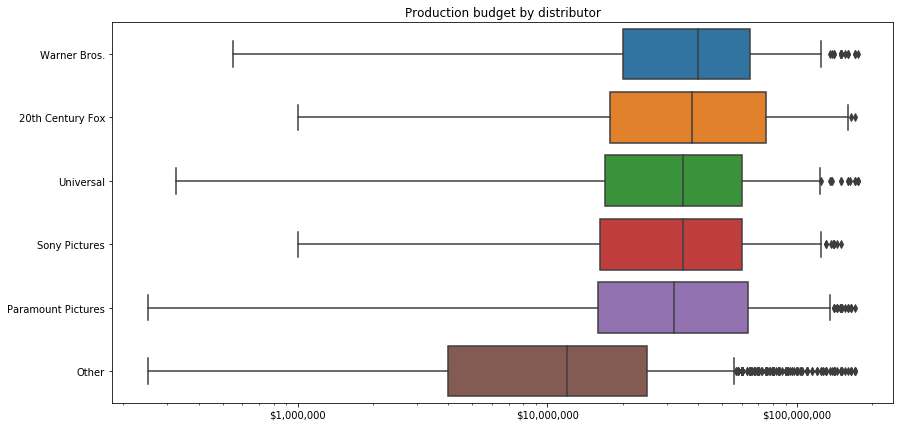

In [18]:
f, ax = plt.subplots(figsize=(14,7))

# rank distributors by highest median production budget
rank = movie_profit.groupby('distributor')['production_budget'].median().sort_values(ascending=False).index

sns.boxplot(x = 'production_budget',
            y = 'distributor', 
            data = movie_profit,
            order = rank,
            orient = 'h')

ax.set_xscale('log', basex=10)
ax.xaxis.set_major_formatter(dollar_formattor)
ax.set_xlabel(None)

ax.set_ylabel(None)

ax.set_title('Production budget by distributor')

plt.show()

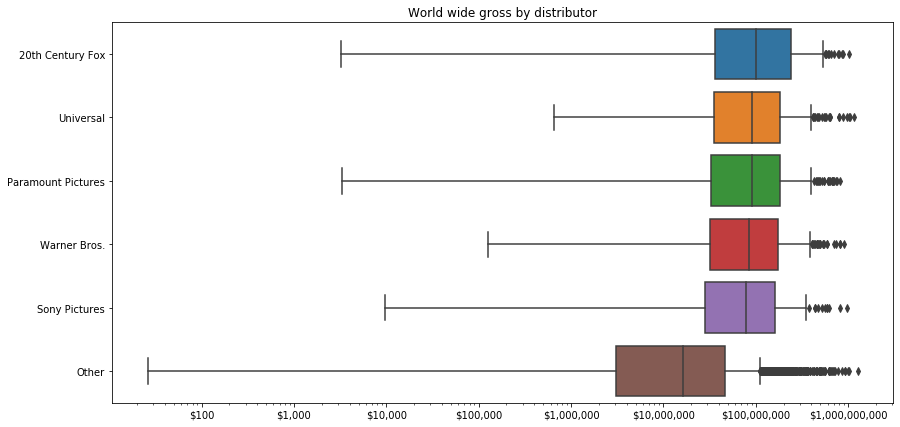

In [19]:
f, ax = plt.subplots(figsize=(14,7))

# rank distributors by highest median worldwide gross
rank = movie_profit.groupby('distributor')['worldwide_gross'].median().sort_values(ascending=False).index

sns.boxplot(x = 'worldwide_gross',
            y = 'distributor', 
            data = movie_profit,
            order = rank,
            orient = 'h')

ax.set_xscale('log', basex=10)
ax.xaxis.set_major_formatter(dollar_formattor)
ax.set_xlabel(None)

ax.set_ylabel(None)

ax.set_title('World wide gross by distributor')

plt.show()